In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, VarianceThreshold, SelectPercentile, SelectFpr, SelectFdr, SelectFwe
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import skew
import numpy as np
from pathlib import Path
import matplotlib.patches as mpatches
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import joblib
import shap

sys.path.append('../../../')

from src.emotion.prediction.aggregates.train_classifier import HyperparaSearchClassifier
from src.emotion.prediction.aggregates.classifier import CLASSIFIER

%matplotlib inline
plt.style.use('ggplot')

# set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features = pd.read_csv('/home/moritz/Workspace/masterthesis/data/features_dataset_big.csv')

In [3]:
targets = pd.read_csv('/home/moritz/Workspace/masterthesis/data/perma_scores_dataset.csv')

In [4]:
df = pd.merge(features, targets, on=["E-Mail-Adresse", "Day"])

df.shape

(103, 9351)

In [5]:
# Handle Missing Values

df.dropna(axis=1, how='any', inplace=True)
#df = dataset.loc[:, (df != 0).any(axis=0)]

print(df.shape)

(103, 9348)


In [6]:
# Detect outliers
# find columns where all values are the same
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
# drop the columns
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

# drop columns where all values are only 0 or 1
df = df.loc[:, ~(df.isin([0, 1]).all() & ~df.isin([0, 1]).any())]
print(df.shape)

(103, 8757)
(103, 8757)


In [7]:
# Load X and Y
# Store the PERMA values in Y
Y = df[['P', 'E', 'R', 'M', 'A']]

# Store the other columns in X
X = df.drop(columns=['ClassID', 'E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname', 'P', 'E', 'R', 'M', 'A'])

In [8]:
# Scale Features
# Create a MinMaxScaler object
minmax_scaler = MinMaxScaler()
gaussian_scaler = StandardScaler()
non_gaussian_scaler = RobustScaler()

# Calculate skewness of each feature
skewness = skew(X, axis=0)

# Create empty list to store scaled features
scaled_features = []

# Scale features using appropriate scaler
for feat, s in zip(X.columns, skewness):
    if abs(s) < 0.5:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    scaled_feat = scaler.fit_transform(X[feat].values.reshape(-1, 1)).flatten()
    scaled_features.append(pd.Series(scaled_feat, name=feat))

# Concatenate scaled features into new DataFrame
scaled_X = pd.concat(scaled_features, axis=1)


# Fit the scaler to the dataframe and transform the dataframe
#scaled_Y = pd.DataFrame(minmax_scaler.fit_transform(Y), columns=['P', 'E', 'R', 'M', 'A'])
scaled_Y = Y

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


In [9]:
# Drop constant features (zero variance)
# var_x = scaled_X.var()
# cols_to_drop = [col for col in scaled_X.columns if var_x[col] == 0]
# scaled_X = scaled_X.drop(cols_to_drop, axis=1)

In [10]:
def assign_class_based_on_median(df):
    # Select only numerical columns
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Calculate the median value of all numerical values in the DataFrame
    median_value = df[numeric_columns].stack().median()

    # Define a helper function to classify values based on the median value
    def classify(value):
        if value < median_value:
            return 0
        else:
            return 1

    # Apply the helper function to each numerical value in the DataFrame
    for col in numeric_columns:
        df[col] = df[col].apply(classify)

    return df

# Assign each numerical value to either class 0 or class 1
scaled_Y = assign_class_based_on_median(scaled_Y)
#print(scaled_Y["E"].value_counts())


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# # Convert the DataFrames to NumPy arrays
# X_np = scaled_X.to_numpy()
# Y_np = scaled_Y.to_numpy()

# # Perform the train/test split
# X_train_np, y_train_np, X_test_np, y_test_np = iterative_train_test_split(X_np, Y_np, test_size=0.2)

# # Convert the NumPy arrays back to DataFrames
# X_train = pd.DataFrame(X_train_np, columns=scaled_X.columns)
# Y_train = pd.DataFrame(y_train_np, columns=scaled_Y.columns)
# X_test = pd.DataFrame(X_test_np, columns=scaled_X.columns)
# Y_test = pd.DataFrame(y_test_np, columns=scaled_Y.columns)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, scaled_Y, test_size=0.2, random_state=42)

In [13]:
# Check the class distributions in the train and test sets
print("Train set class distribution:")
for col in scaled_Y.columns:
    print(f"{col}: {Y_train[col].mean()}")

print("\nTest set class distribution:")
for col in scaled_Y.columns:
    print(f"{col}: {Y_test[col].mean()}")

Train set class distribution:
P: 0.4878048780487805
E: 0.4634146341463415
R: 0.5853658536585366
M: 0.5365853658536586
A: 0.5975609756097561

Test set class distribution:
P: 0.47619047619047616
E: 0.5238095238095238
R: 0.5238095238095238
M: 0.47619047619047616
A: 0.5714285714285714


In [14]:
def get_selected_voting_features_combined(Y, X, filter_methods, wrapper_methods, k):
    
    feature_counts = np.zeros(X.shape[1])

    # Apply filter methods
    for _, method in filter_methods.items():
        method.fit(X, Y)
        selected_i = method.get_support(indices=True)
        print(len(selected_i))
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1

    # Apply wrapper methods
    for _, method in wrapper_methods.items():
        method.fit(X, Y)
        selected_i = method.get_support(indices=True)
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1
    
    # Get the indices of the top k features with the most counts
    #selected_features = np.argsort(feature_counts)[-k:]
    selected_features = np.where(feature_counts >= k)[0]
    print(np.sort(feature_counts))
    
    return selected_features

In [15]:
np.random.seed(42)

# Create a dictionary for each PERMA pillar
perma_dict = {
    "P": None,
    "E": None,
    "R": None,
    "M": None,
    "A": None,
}

filter_methods = {
    #'chi2': SelectKBest(chi2, k=8),
    'f_classif': SelectKBest(f_classif, k=8),
    'mutual_info_classif': SelectKBest(mutual_info_classif, k=8),
    #'variance_threshold': VarianceThreshold(threshold=2.0),
    'select_percentile': SelectPercentile(f_classif, percentile=0.5),
    'select_fpr': SelectFpr(f_classif, alpha=0.005),
    #'select_fdr': SelectFdr(f_classif, alpha=0.915),
    'select_fwe': SelectFwe(f_classif, alpha=1.0),
    #'rfe_classification': RFEC(LogisticRegression(), n_features_to_select=8),
}

wrapper_methods = {
    #'sfs_classification': SequentialFeatureSelector(LogisticRegression(), n_features_to_select=8, direction='forward', n_jobs=-1),
    #'sbs_classification': SequentialFeatureSelector(LogisticRegression(), n_features_to_select=8, direction='backward', n_jobs=-1),
}

# Iterate over each PERMA dimension in Y
for i, perma_dim in enumerate(Y.columns):
    # Get the selected features for the current PERMA dimension
    selected_features = get_selected_voting_features_combined(Y_train.iloc[:, i], X_train, filter_methods, wrapper_methods, k=3)
    # Save the selected features in the corresponding dictionary for the current PERMA pillar
    perma_dict[perma_dim] = selected_features

# Print the selected features for each PERMA dimension in each PERMA pillar
for pillar in perma_dict:
    print(pillar, ":", perma_dict[pillar])

Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide


8
8
44
24
0
[0. 0. 0. ... 3. 3. 3.]


Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide


8
8
44
28
1
[0. 0. 0. ... 3. 3. 4.]
8


Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide


8
44
301
17
[0. 0. 0. ... 4. 4. 4.]
8


Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide


8
44


Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide


36
2
[0. 0. 0. ... 3. 4. 4.]


Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide


8
8
44
18
1
[0. 0. 0. ... 3. 4. 5.]
P : [1698 1734 1958 3455 4219 4962 6797 6816]
E : [ 291  604 1749 3797 5241 5706 6700 7881]
R : [  41   80  626  627 1772 1952 1958 1974 2807 2987 4866 5095 5582 5825
 5850 6553 7895]
M : [2276 2277 2281 2285 2743 3243 3895 4453 4457]
A : [2575 3912 4039 4238 4585 4763 6883 6986]


Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide
Features [2165 5065 5790 5791 7249 7250] are constant.
invalid value encountered in true_divide


In [16]:
feature_sets = {
    "P": {"train": None, "test": None},
    "E": {"train": None, "test": None},
    "R": {"train": None, "test": None},
    "M": {"train": None, "test": None},
    "A": {"train": None, "test": None}
}

for perma_dim, selected_features in perma_dict.items():
    # Select the corresponding columns of X_filtered
    X_train_final = X_train.iloc[:, list(set(selected_features))]
    #X_test_final = X_test.iloc[:, list(set(selected_features))]
    column_names = X_train_final.columns.tolist()
    X_test_final = X_test[column_names]
    # Add the selected features for the current PERMA dimension to the feature sets dictionary
    feature_sets[perma_dim]["train"] = X_train_final
    feature_sets[perma_dim]["test"] = X_test_final
    # Print the names of the selected features
    column_names = X_train_final.columns.tolist()
    print(perma_dim, ":", column_names)

P : ['Dominance__fft_coefficient__attr_"real"__coeff_52', 'Happy__fft_coefficient__attr_"real"__coeff_17', 'Neutral__fft_coefficient__attr_"angle"__coeff_80', 'Happy__fft_coefficient__attr_"abs"__coeff_78', 'Happy__fft_coefficient__attr_"real"__coeff_53', 'Dominance__fft_coefficient__attr_"real"__coeff_33', 'Fear__fft_coefficient__attr_"angle"__coeff_61', 'Surprise__fft_coefficient__attr_"angle"__coeff_23']
E : ['Angry__fft_coefficient__attr_"real"__coeff_63', 'Brightness__fft_coefficient__attr_"angle"__coeff_87', 'Valence__fft_aggregated__aggtype_"skew"', 'Dominance__ar_coefficient__coeff_7__k_10', 'Fear__ar_coefficient__coeff_8__k_10', 'Happy__fft_coefficient__attr_"real"__coeff_68', 'Valence__ar_coefficient__coeff_7__k_10', 'Angry__fft_coefficient__attr_"angle"__coeff_78']
R : ['Happy__fft_coefficient__attr_"abs"__coeff_72', 'Arousal__absolute_sum_of_changes', 'Neutral__fft_coefficient__attr_"abs"__coeff_83', 'Happy__fft_coefficient__attr_"abs"__coeff_78', 'Valence__absolute_sum_of_

In [17]:
SAVE_DIR_CLASSIFIER = Path("/home/moritz/Workspace/masterthesis/model/custom_models/classifier/big")

eval_metric = "accuracy"

In [18]:
from catboost import CatBoostClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

CLASSIFIER = [
    {
        "name": "MLPClassifier",
        "model": MLPClassifier(max_iter=2000),
        "params": {
            "hidden_layer_sizes": [(64, 32), (128, 64)],
            "alpha": [0.001, 0.01, 0.1],
            "learning_rate_init": [0.001, 0.01, 0.1],
        },
    },
    {
        "name": "KNeighborsClassifier",
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [1, 5, 10, 15, 20]},
    },
    {
        "name": "DecisionTreeClassifier",
        "model": DecisionTreeClassifier(),
        "params": {"max_depth": range(2, 11),
                   "random_state": [42]},
    },
    {
        "name": "RandomForestClassifier",
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "class_weight": ["balanced", "balanced_subsample"],
        },
    },
    {
        "name": "ExtraTreesClassifier",
        "model": ExtraTreesClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "class_weight": ["balanced", "balanced_subsample"],
        },
    },
    {
        "name": "GradientBoostingClassifier",
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1],
        },
    },
    {
        "name": "AdaBoostClassifier",
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "learning_rate": [0.001, 0.01, 0.1],
        },
    },
    {
        "name": "SVC",
        "model": SVC(),
        "params": {
            "kernel": ["linear", "rbf"],
            "C": [0.1, 1.0, 10.0],
            "shrinking": [True, False],
            "class_weight": ["balanced"],
        },
    },
    {
        "name": "LogisticRegression",
        "model": LogisticRegression(max_iter=2000),
        "params": {
            "C": [0.001, 0.01, 0.1, 1.0],
            "penalty": ["l1", "l2", "elasticnet"],
            "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
            "class_weight": ["balanced"],
        },
    },
    {
        "name": "RidgeClassifier",
        "model": RidgeClassifier(),
        "params": {
            "alpha": [0.001, 0.01, 0.1, 1.0],
            "class_weight": ["balanced"],
        },
    },
    {
        "name": "GaussianNB",
        "model": GaussianNB(),
        "params": {"var_smoothing": [1e-9, 1e-8, 1e-7]},
    },
    {
        "name": "CatBoostClassifier",
        "model": CatBoostClassifier(verbose=False),
        "params": {
            "iterations": [50, 100, 200, 400],
            "depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1, 1.0],
            "auto_class_weights": ["Balanced", "SqrtBalanced"],
        },
    },
    {
        "name": "XGBClassifier",
        "model": XGBClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1],
            "scale_pos_weight": [99],
        },
    },
]

In [19]:
classifier_to_drop = ["MLPClassifier", "KNeighborsClassifier", "GradientBoostingClassifier"]

for name in classifier_to_drop:
    for i in range(len(CLASSIFIER)):
        if CLASSIFIER[i]["name"] == name:
            del CLASSIFIER[i]
            break
        
for classifier in CLASSIFIER:
    print(classifier["name"])

DecisionTreeClassifier
RandomForestClassifier
ExtraTreesClassifier
AdaBoostClassifier
SVC
LogisticRegression
RidgeClassifier
GaussianNB
CatBoostClassifier
XGBClassifier


In [20]:
results_classifier_dict = {}

for perma_dim, X_final in feature_sets.items():
    print(f"PERMA dimension: {perma_dim}")
    # Run the hyperparameter search
    models_path = SAVE_DIR_CLASSIFIER / perma_dim
    X_train = X_final["train"]
    search = HyperparaSearchClassifier(models=CLASSIFIER, metrics=["accuracy"], models_path = models_path, n_folds=5, n_jobs=-1, mode="uni")  
    results = search.run(X_train, Y_train[perma_dim], save=True)
    results_classifier_dict[perma_dim] = results
    # Print the model with the lowest score
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    print(perma_dim)
    print(f"Best model: {best_model['name']}")
    print(f"Best params: {best_model['params']}")
    print(f"Best Score: {best_model['score']}")

PERMA dimension: P


/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/skl

Models for DecisionTreeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/P/DecisionTreeClassifier.joblib
Models for RandomForestClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/P/RandomForestClassifier.joblib
Models for ExtraTreesClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/P/ExtraTreesClassifier.joblib
Models for AdaBoostClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/P/AdaBoostClassifier.joblib
Models for SVC saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/P/SVC.joblib
Models for LogisticRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/P/LogisticRegression.joblib
Models for RidgeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/P/RidgeClassifier.joblib
Models for GaussianNB saved to /home/moritz/Worksp

/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/skl

Models for DecisionTreeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/E/DecisionTreeClassifier.joblib
Models for RandomForestClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/E/RandomForestClassifier.joblib
Models for ExtraTreesClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/E/ExtraTreesClassifier.joblib
Models for AdaBoostClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/E/AdaBoostClassifier.joblib
Models for SVC saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/E/SVC.joblib
Models for LogisticRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/E/LogisticRegression.joblib
Models for RidgeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/E/RidgeClassifier.joblib
Models for GaussianNB saved to /home/moritz/Worksp

/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/skl

Models for DecisionTreeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/R/DecisionTreeClassifier.joblib
Models for RandomForestClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/R/RandomForestClassifier.joblib
Models for ExtraTreesClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/R/ExtraTreesClassifier.joblib
Models for AdaBoostClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/R/AdaBoostClassifier.joblib
Models for SVC saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/R/SVC.joblib
Models for LogisticRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/R/LogisticRegression.joblib
Models for RidgeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/R/RidgeClassifier.joblib
Models for GaussianNB saved to /home/moritz/Worksp

/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/skl

Models for DecisionTreeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/M/DecisionTreeClassifier.joblib
Models for RandomForestClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/M/RandomForestClassifier.joblib
Models for ExtraTreesClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/M/ExtraTreesClassifier.joblib
Models for AdaBoostClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/M/AdaBoostClassifier.joblib
Models for SVC saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/M/SVC.joblib
Models for LogisticRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/M/LogisticRegression.joblib
Models for RidgeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/M/RidgeClassifier.joblib
Models for GaussianNB saved to /home/moritz/Worksp

/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/skl

Models for DecisionTreeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/A/DecisionTreeClassifier.joblib
Models for RandomForestClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/A/RandomForestClassifier.joblib
Models for ExtraTreesClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/A/ExtraTreesClassifier.joblib
Models for AdaBoostClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/A/AdaBoostClassifier.joblib
Models for SVC saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/A/SVC.joblib
Models for LogisticRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/A/LogisticRegression.joblib
Models for RidgeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/big/A/RidgeClassifier.joblib
Models for GaussianNB saved to /home/moritz/Worksp

In [21]:
best_models = {}

for perma_dim, results in results_classifier_dict.items():
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    # print(perma_dim)
    # print(f"Best model: {best_model['name']}")
    # print(f"Best params: {best_model['params']}")
    # print(f"Best Score: {best_model['score']}")
    best_models[perma_dim] = best_model['name']

In [22]:
def load_best_model(file_path: Path):

    models = {}

    if file_path.is_file():
        model = joblib.load(file_path)

        models[str(file_path.stem)] = model

    return models

In [23]:
perma_models = {}

for perma_dim in ["P", "E", "R", "M", "A"]:
    models_path = SAVE_DIR_CLASSIFIER / perma_dim / (best_models[perma_dim] + ".joblib")
    models = load_best_model(models_path)
    perma_models[perma_dim] = models

In [24]:
def generate_predictions(models, X, y):
    # Generate and return a dictionary of balanced accuracy scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        # Make predictions
        y_pred = model.predict(X)
        # Calculate balanced accuracy score
        balanced_accuracy = balanced_accuracy_score(y, y_pred)
        results[model_name] = {"accuracy": balanced_accuracy, "y_pred": y_pred}
    return results


In [25]:
def generate_shap_values(dim, models, X):
    for i, (model_name, mae_grid_search) in enumerate(models.items()):
        model = mae_grid_search[0].best_estimator_
        print(model_name)
        path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results/big_classif_shap"
        image = path + "/" + dim[i].lower() + "_big_classif.pdf"

        if model_name in ["LogisticRegression", "RidgeClassifier"]:
            explainer = shap.LinearExplainer(model, X, feature_names=X.columns)
            shap_values = explainer(X)
            shap.summary_plot(shap_values, X, plot_size=(13, 3), plot_type='violin', show=False, max_display=10)
        elif model_name in ["AdaBoostClassifier", "GaussianNB", "DecisionTreeClassifier"]:
            explainer = shap.SamplingExplainer(model.predict, X)
            shap_values = explainer(X)
            shap.summary_plot(shap_values, X, plot_size=(13, 3), plot_type='violin', show=False, max_display=10)
        elif model_name in ["SVC"]:
            explainer = shap.KernelExplainer(model.predict, X)
            shap_values = explainer(X)
            shap.summary_plot(shap_values, X, plot_size=(13, 3), plot_type='violin', show=False, max_display=10)
        elif model_name in ["CatBoostClassifier"]:
            explainer = shap.Explainer(model, feature_names=X.columns)
            shap_values = explainer(X)
            shap.summary_plot(shap_values, X, plot_size=(13, 3), plot_type='violin', show=False, max_display=10)
        else:
            explainer = shap.TreeExplainer(model, feature_names=X.columns)
            shap_values = explainer(X)
            shap.summary_plot(shap_values, X, plot_size=(13, 3), plot_type='violin', show=False, max_display=10)
            
        plt.savefig(image, bbox_inches='tight', dpi=300)
        plt.close()  # close the plot


In [26]:
for dim, models in perma_models.items():
    print(dim)
    X_test = feature_sets[dim]["train"]
    X_test.columns = [col.lower() for col in X_test.columns]
    generate_shap_values(dim, models, X_test)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


P
DecisionTreeClassifier


  0%|          | 0/82 [00:00<?, ?it/s]X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid 

E
AdaBoostClassifier


  0%|          | 0/82 [00:00<?, ?it/s]X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier wa

R
DecisionTreeClassifier


  0%|          | 0/82 [00:00<?, ?it/s]X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid 

M
XGBClassifier


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


A
XGBClassifier


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [27]:
perma_results = {}

for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    results = generate_predictions(models, X_test, Y_test[dim])
    perma_results[dim] = results

In [28]:
def print_models(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        if model_name == "CatBoostClassifier":
            print(model.get_params())
        else:
            print(model)
        
for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    print_models(models, X_test, Y_test[dim])

DecisionTreeClassifier(max_depth=5, random_state=42)
AdaBoostClassifier(learning_rate=0.1)
DecisionTreeClassifier(max_depth=4, random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

In [29]:
best_results = {}

for dim, results in perma_results.items():
    curr_mae = float("inf")
    for model in results:
        if results[model]["accuracy"] < curr_mae:
            curr_mae = results[model]["accuracy"]
            best_results[dim] = {"model": model, "accuracy": results[model]["accuracy"], "preds": results[model]["y_pred"]}
            
print(best_results)

{'P': {'model': 'DecisionTreeClassifier', 'accuracy': 0.3727272727272727, 'preds': array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0])}, 'E': {'model': 'AdaBoostClassifier', 'accuracy': 0.4318181818181818, 'preds': array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1])}, 'R': {'model': 'DecisionTreeClassifier', 'accuracy': 0.6727272727272727, 'preds': array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0])}, 'M': {'model': 'XGBClassifier', 'accuracy': 0.6272727272727273, 'preds': array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1])}, 'A': {'model': 'XGBClassifier', 'accuracy': 0.5416666666666666, 'preds': array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])}}


In [30]:
# Baseline:
accuracy_baseline = [0.5, 0.5, 0.5, 0.5, 0.5]

print(f"Baseline accuracy for each dimension: {accuracy_baseline}")

Baseline accuracy for each dimension: [0.5, 0.5, 0.5, 0.5, 0.5]


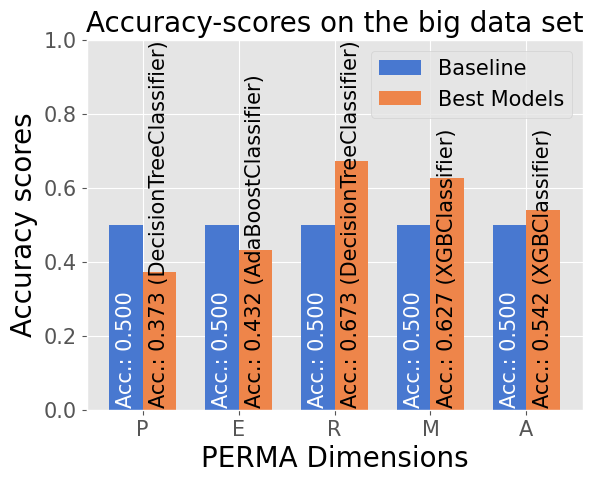

In [31]:
# Print the best model for each PERMA dimension
best_accuracy_values = [v['accuracy'] for v in best_results.values()]

# Define the x-axis labels and the bar width
perma_dimensions = ['P', 'E', 'R', 'M', 'A']
bar_width = 0.35

# Set up the plot
fig, ax = plt.subplots()
palette = sns.color_palette("muted")
ax.set_prop_cycle(color=palette)
ax.bar(np.arange(len(perma_dimensions)), accuracy_baseline, width=bar_width, label='Baseline')
ax.bar(np.arange(len(perma_dimensions))+bar_width, best_accuracy_values, width=bar_width, label='Best Models')

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(len(perma_dimensions))+bar_width/2)
ax.set_xticklabels(perma_dimensions)
ax.set_xlabel('PERMA Dimensions', fontsize=20)

# Set the y-axis label and limits
ax.set_ylabel('Accuracy scores', fontsize=20)
ax.set_ylim([0, max(np.max(accuracy_baseline), np.max(best_accuracy_values))*1.1])
ax.tick_params(axis='both', which='major', labelsize=15)

# Add the model names and MAE values above each bar
for i, v in enumerate(accuracy_baseline):
    ax.text(i, 0.005, f"Acc.: {v:.3f}", rotation=90, ha='center', va='bottom', fontsize=15, color='white')
    model = best_results[perma_dimensions[i]]['model']
    ax.text(i+bar_width, 0.005, f"Acc.: {best_accuracy_values[i]:.3f} ({model})", rotation=90, ha='center', va='bottom', fontsize=15, color='black')

# Add a legend and title
ax.legend(fontsize=15)
ax.set_title('Accuracy-scores on the big data set', fontsize=20)
ax.set_ylim([0, 1.0])

path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
image = path + "/accur_big.pdf"
plt.savefig(image, bbox_inches='tight', dpi=300)